In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from test_helper import *

from scipy.spatial.distance import cdist
from matplotlib import gridspec
import argparse

import os
import textwrap as tw

os.environ['CUDA_VISIBLE_DEVICES'] = '1'


In [2]:
val_dataset = combine_dataset(batch_size=1, image_size=[256, 128], same_prob=0.5, diff_prob=0.5, train=False)
handle = tf.placeholder(tf.string, shape=[])

iterator = tf.data.Iterator.from_string_handle(
            handle, val_dataset.output_types, val_dataset.output_shapes)

val_iterator = val_dataset.make_one_shot_iterator()

left, right = iterator.get_next()
left_input_im, left_label, left_addr = left
right_input_im, right_label, right_addr = right

logits, model_left, model_right = inference(left_input_im, right_input_im)

global_step = tf.Variable(0, trainable=False)

global_init = tf.variables_initializer(tf.global_variables())

(?, 256, 128, 3)
(?, 256, 128, 256)
(?, 128, 64, 256)
(?, 128, 64, 128)
(?, 64, 32, 128)
(?, 64, 32, 64)
(?, 32, 16, 64)
(?, 32, 16, 32)
(?, 16, 8, 32)
(?, 4096)
(?, 4096)
(?, 256, 128, 3)
(?, 256, 128, 256)
(?, 128, 64, 256)
(?, 128, 64, 128)
(?, 64, 32, 128)
(?, 64, 32, 64)
(?, 32, 16, 64)
(?, 32, 16, 32)
(?, 16, 8, 32)
(?, 4096)
(?, 4096)


INFO:tensorflow:Restoring parameters from model_siamese/epoch_5/model.ckpt


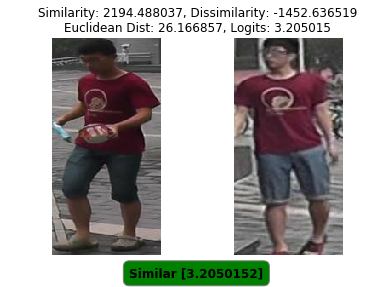

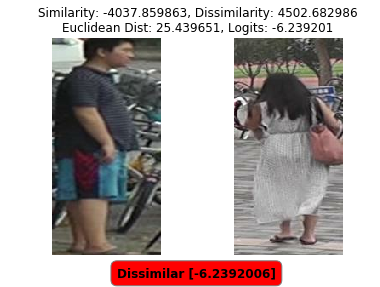

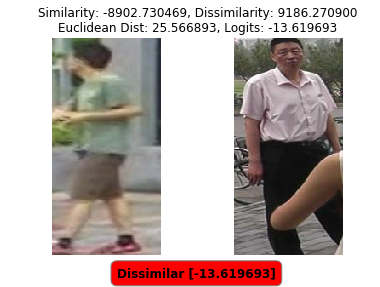

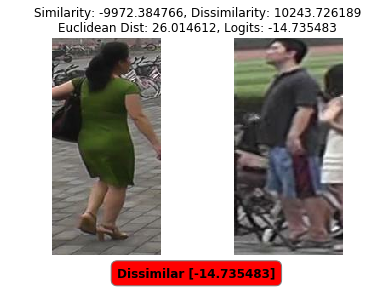

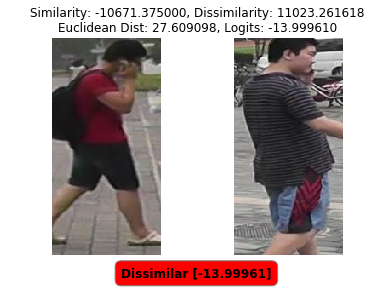

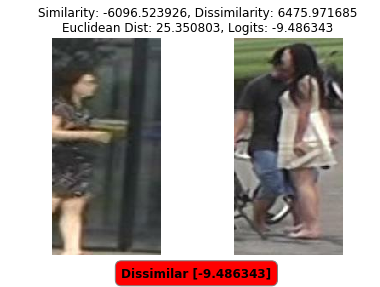

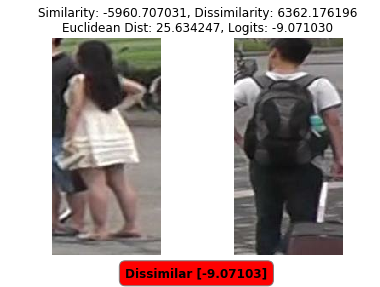

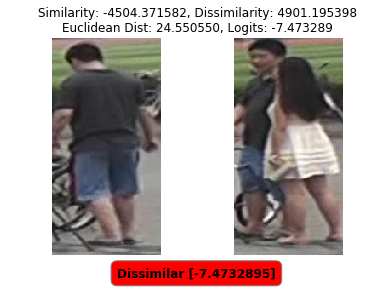

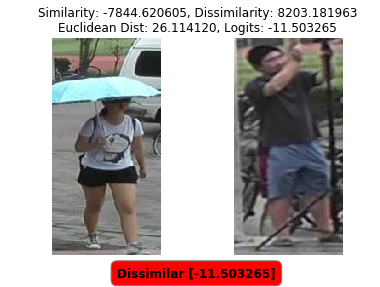

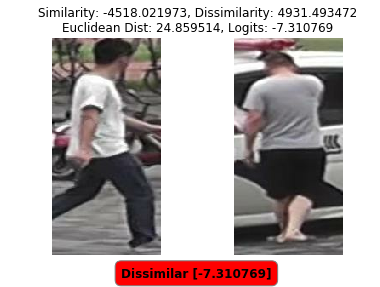

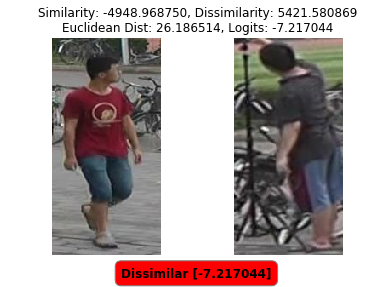

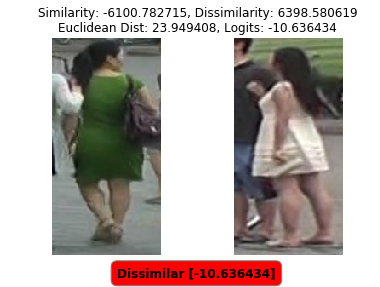

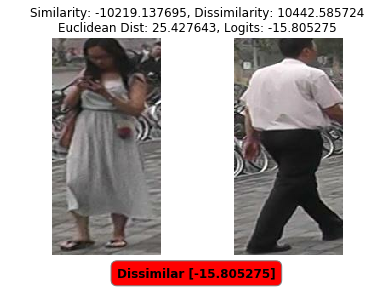

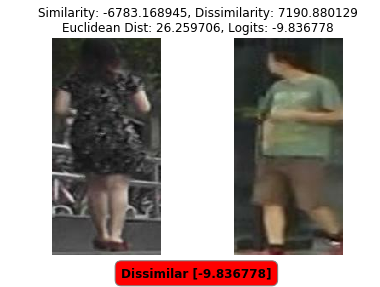

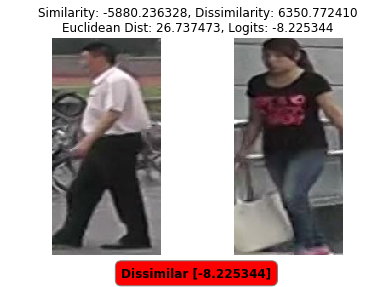

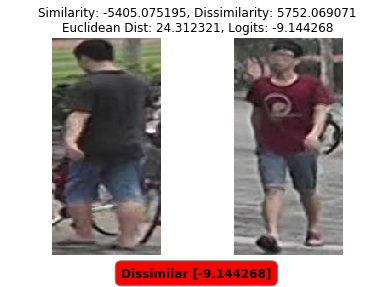

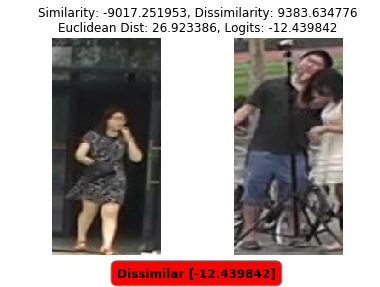

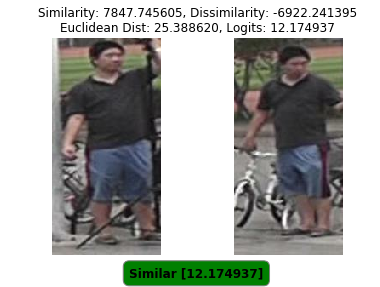

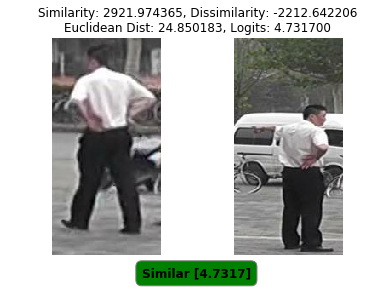

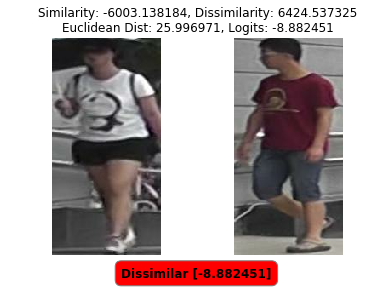

In [5]:
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(global_init)
    ckpt = tf.train.get_checkpoint_state("model")
    saver.restore(sess, "model_siamese/model.ckpt")
    
    validation_handle = sess.run(val_iterator.string_handle())
    
    for i in range(20):
        validation_handle = sess.run(val_iterator.string_handle())
        feed_dict_val = {handle:validation_handle}
        
        model_lf, model_rg, my_logits, lft_lbl, rgt_lbl, l_img, r_img = \
        sess.run([model_left, model_right, logits, left_label, right_label, \
                  left_input_im, right_input_im], feed_dict_val)

        lft = np.array(model_lf[0])
        rgt = np.array(model_rg[0])
        l = lft - rgt

        distance = np.sqrt(np.sum((l) ** 2))
        similarity = my_logits * np.square(distance)  # keep the similar label (1) close to each other
        dissimilarity = (1 - np.array(my_logits[0])) * np.square(np.max((0.5 - distance),
                                                                        0))  # give penalty to dissimilar label if the distance is bigger than margin
        similarity_loss = np.mean(dissimilarity + similarity) / 2

        dist = cdist(model_lf, model_rg, 'cosine')
        euc = np.linalg.norm(model_lf - model_rg)

        fig = plt.figure()
        plt.title(('Similarity: %f, Dissimilarity: %f\nEuclidean Dist: %f, Logits: %f' % (similarity, dissimilarity, euc, my_logits)), loc='center')
        if my_logits > 0.0:
            textstr = 'Similar ' + str(my_logits)
            props = dict(boxstyle='round', facecolor='green', alpha=0.5)
            fig_txt = tw.fill(tw.dedent(textstr), width=80)
            plt.figtext(0.51, 0.05, fig_txt, horizontalalignment='center',
                        fontsize=12, multialignment='center',
                        bbox=dict(boxstyle="round", facecolor='green',
                                  ec="0.5", pad=0.5, alpha=1), fontweight='bold')
        else:
            textstr = 'Dissimilar ' + str(my_logits)
            props = dict(boxstyle='round', facecolor='red', alpha=0.5)
            fig_txt = tw.fill(tw.dedent(textstr), width=80)
            plt.figtext(0.51, 0.05, fig_txt, horizontalalignment='center',
                        fontsize=12, multialignment='center',
                        bbox=dict(boxstyle="round", facecolor='red',
                                  ec="0.5", pad=0.5, alpha=1), fontweight='bold')



        plt.axis('off')
        ax1 = fig.add_subplot(1, 2, 1)
        l_im = np.array(l_img)[0] * 255.0
        ax1.imshow(l_im)
        ax1.axis('off')
        ax2 = fig.add_subplot(1, 2, 2)
        r_im = np.array(r_img)[0] * 255.0
        ax2.imshow(r_im)
        ax2.axis('off')


        plt.show()
             
        
        